# build model prediction and compare each features set

In [ ]:
import pandas as pd
import xgboost as xgb
import pickle
import numpy as np
import os

from gensim.models import Doc2Vec, doc2vec

## turn back to main directory
os.chdir("../")
os.getcwd()

In [ ]:
## read preprocess article df
df = pd.read_csv('data/article_preprocessed.csv')

In [ ]:
## drop data
diff_threshold = 20
df = df[abs(df['push']-df['boo']) > diff_threshold].copy()

In [ ]:
## define y
df['type'] = np.clip(df['push']-df['boo'], 0, 1)
df = df.reset_index(drop=True)

In [ ]:
df['type'].value_counts()

In [6]:
## create a numpy format data
basic_data = np.zeros((df.shape[0], 258))

In [7]:
basic_data[:, 0] = df['idx']
basic_data[:, 1] = df['type']

## bag of words

In [8]:
## load bag of words result
with open('article_count', 'rb') as file:
    _, count = pickle.load(file)

In [9]:
## select top 256 words (counts of document) 
most_count_id = np.array((count > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [10]:
## subset data
count = count[:, most_count_id]

In [11]:
count_data = basic_data.copy()

In [12]:
## subset bag of words matrix
count_data[:, 2:] = count[count_data[:, 0]].toarray()

## TF-IDF

In [13]:
## load tf-idf result
with open('article_tfidf', 'rb') as file:
    _, tfidf = pickle.load(file)

In [14]:
## select top 256 words (counts of document) 
most_tfidf_id = np.array((tfidf > 0).sum(axis=0))[0].argsort()[::-1][:256]

In [15]:
## subset data
tfidf = tfidf[:, most_tfidf_id]

In [16]:
tfidf_data = basic_data.copy()

In [17]:
## subset tf-idf matrix
tfidf_data[:, 2:] = tfidf[tfidf_data[:, 0]].toarray()

## average word2vec

In [18]:
## load average word2vec result
with open('avg_article_vector', 'rb') as file:
    avg_vector = pickle.load(file)

In [19]:
avg_data = basic_data.copy()

In [20]:
## select rows of average word2vec
for i, row in df.iterrows():
    avg_data[i, 2:] = avg_vector[row['idx']]

## doc2vec

In [21]:
## load doc2vec model (由 05_document_vector.ipynb 產生)
model = Doc2Vec.load('word2vec_model/doc2vec')

In [22]:
doc2vec_data = basic_data.copy()

In [23]:
## select idx of doc2vec
for i, row in df.iterrows():
    doc2vec_data[i, 2:] = model.docvecs[str(row['idx'])]

# prediction model

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
## split data to training and testing data
train, test = train_test_split(df, test_size=0.2, stratify=df['type'])
train_idx = np.array(train.index)
test_idx = np.array(test.index)

In [26]:
## define a dictionary to collect model result
result = {}

## train model use xgboost

In [27]:
## bag of words
model = xgb.XGBClassifier()
model.fit(count_data[train_idx, 2:], count_data[train_idx, 1], 
          eval_set=[(count_data[test_idx, 2:], count_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['bag_of_words'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.546242
[1]	validation_0-auc:0.561359
[2]	validation_0-auc:0.561102
[3]	validation_0-auc:0.561053
[4]	validation_0-auc:0.56115
[5]	validation_0-auc:0.561187
[6]	validation_0-auc:0.560785
[7]	validation_0-auc:0.562859
[8]	validation_0-auc:0.567249
[9]	validation_0-auc:0.580196
[10]	validation_0-auc:0.58046
[11]	validation_0-auc:0.589906
[12]	validation_0-auc:0.592079
[13]	validation_0-auc:0.592171
[14]	validation_0-auc:0.613744
[15]	validation_0-auc:0.613754
[16]	validation_0-auc:0.61448
[17]	validation_0-auc:0.616562
[18]	validation_0-auc:0.617025
[19]	validation_0-auc:0.617031
[20]	validation_0-auc:0.614456
[21]	validation_0-auc:0.650402
[22]	validation_0-auc:0.662223
[23]	validation_0-auc:0.661834
[24]	validation_0-auc:0.661632
[25]	validation_0-auc:0.66423
[26]	validation_0-auc:0.664639
[27]	validation_0-auc:0.666412
[28]	validation_0-auc:0.665746
[29]	validation_0-auc:0.67559
[30]	validation_0-auc:0.677994
[31]	validation_0-auc:0.686512
[32]	validation_0-auc:0

In [28]:
## tf-idf
model = xgb.XGBClassifier()
model.fit(tfidf_data[train_idx, 2:], tfidf_data[train_idx, 1], 
          eval_set=[(tfidf_data[test_idx, 2:], tfidf_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['tf-idf'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.546242
[1]	validation_0-auc:0.561359
[2]	validation_0-auc:0.561102
[3]	validation_0-auc:0.561053
[4]	validation_0-auc:0.56115
[5]	validation_0-auc:0.561187
[6]	validation_0-auc:0.560785
[7]	validation_0-auc:0.562859
[8]	validation_0-auc:0.567249
[9]	validation_0-auc:0.580196
[10]	validation_0-auc:0.58046
[11]	validation_0-auc:0.589906
[12]	validation_0-auc:0.592079
[13]	validation_0-auc:0.592171
[14]	validation_0-auc:0.613744
[15]	validation_0-auc:0.613754
[16]	validation_0-auc:0.61448
[17]	validation_0-auc:0.616562
[18]	validation_0-auc:0.617025
[19]	validation_0-auc:0.617031
[20]	validation_0-auc:0.614456
[21]	validation_0-auc:0.650402
[22]	validation_0-auc:0.662223
[23]	validation_0-auc:0.661834
[24]	validation_0-auc:0.661632
[25]	validation_0-auc:0.66423
[26]	validation_0-auc:0.664639
[27]	validation_0-auc:0.666412
[28]	validation_0-auc:0.665746
[29]	validation_0-auc:0.67559
[30]	validation_0-auc:0.677994
[31]	validation_0-auc:0.686512
[32]	validation_0-auc:0

In [29]:
## average word2vec
model = xgb.XGBClassifier()
model.fit(avg_data[train_idx, 2:], avg_data[train_idx, 1], 
          eval_set=[(avg_data[test_idx, 2:], avg_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['avg_word2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.706458
[1]	validation_0-auc:0.744211
[2]	validation_0-auc:0.768376
[3]	validation_0-auc:0.777087
[4]	validation_0-auc:0.77968
[5]	validation_0-auc:0.783213
[6]	validation_0-auc:0.78664
[7]	validation_0-auc:0.788344
[8]	validation_0-auc:0.784422
[9]	validation_0-auc:0.786199
[10]	validation_0-auc:0.785926
[11]	validation_0-auc:0.784418
[12]	validation_0-auc:0.787729
[13]	validation_0-auc:0.78545
[14]	validation_0-auc:0.785803
[15]	validation_0-auc:0.783185
[16]	validation_0-auc:0.782471
[17]	validation_0-auc:0.787612
[18]	validation_0-auc:0.786735
[19]	validation_0-auc:0.791102
[20]	validation_0-auc:0.794901
[21]	validation_0-auc:0.793568
[22]	validation_0-auc:0.792271
[23]	validation_0-auc:0.79489
[24]	validation_0-auc:0.796878
[25]	validation_0-auc:0.801739
[26]	validation_0-auc:0.803528
[27]	validation_0-auc:0.802816
[28]	validation_0-auc:0.805968
[29]	validation_0-auc:0.804448
[30]	validation_0-auc:0.807098
[31]	validation_0-auc:0.810668
[32]	validation_0-auc:

In [30]:
## doc2vec
model = xgb.XGBClassifier()
model.fit(doc2vec_data[train_idx, 2:], doc2vec_data[train_idx, 1],
          eval_set=[(doc2vec_data[test_idx, 2:], doc2vec_data[test_idx, 1])], eval_metric='auc'
         )

## testing auc
result['doc2vec'] = model.evals_result()['validation_0']['auc'][-1]

[0]	validation_0-auc:0.623607
[1]	validation_0-auc:0.62853
[2]	validation_0-auc:0.64362
[3]	validation_0-auc:0.647805
[4]	validation_0-auc:0.652269
[5]	validation_0-auc:0.668071
[6]	validation_0-auc:0.675563
[7]	validation_0-auc:0.679854
[8]	validation_0-auc:0.698514
[9]	validation_0-auc:0.706411
[10]	validation_0-auc:0.716169
[11]	validation_0-auc:0.721925
[12]	validation_0-auc:0.715822
[13]	validation_0-auc:0.724785
[14]	validation_0-auc:0.728572
[15]	validation_0-auc:0.731816
[16]	validation_0-auc:0.737322
[17]	validation_0-auc:0.739229
[18]	validation_0-auc:0.740947
[19]	validation_0-auc:0.73689
[20]	validation_0-auc:0.740999
[21]	validation_0-auc:0.746457
[22]	validation_0-auc:0.747509
[23]	validation_0-auc:0.743021
[24]	validation_0-auc:0.742211
[25]	validation_0-auc:0.744645
[26]	validation_0-auc:0.746374
[27]	validation_0-auc:0.743138
[28]	validation_0-auc:0.744549
[29]	validation_0-auc:0.747697
[30]	validation_0-auc:0.751583
[31]	validation_0-auc:0.754461
[32]	validation_0-auc

## plot result

In [31]:
import matplotlib.pyplot as plt

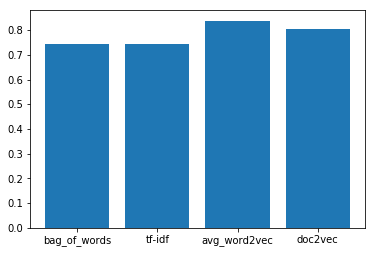

In [32]:
plt.bar(np.arange(4), result.values())
plt.xticks(np.arange(4), result.keys())
plt.show()